# Hyperparameter Tuning

In this notebook we simulate using boax for a hyperparemter tuning problem of a SVM.

We will begin by defining the latent objective function we want to maximize and its bounds.

In [6]:
from jax import config

# Double precision is highly recommended.
config.update("jax_enable_x64", True)

from jax import jit
from jax import lax
from jax import nn
from jax import numpy as jnp
from jax import random
from jax import scipy
from jax import value_and_grad

import optax
import matplotlib.pyplot as plt

from boax.prediction import kernels, means, models
from boax.optimization import acquisitions, maximizers, samplers

We use a two-dimensional synthetic objective funtion simulating the accuracy of a SVM.

In [2]:
bounds = jnp.array([[0.0, 2.0], [0.0, 2.0]])

In [3]:
def objective(x):
    return (
        jnp.sin(5 * x[..., 0] / 2 - 2.5) * jnp.cos(2.5 - 5 * x[..., 1])
        + (5 * x[..., 1] / 2 + 0.5) ** 2 / 10
    ) / 5 + 0.2

In [4]:
x0 = jnp.linspace(bounds[0, 0], bounds[0, 1], 101)
x1, x2 = jnp.meshgrid(x0, x0, indexing="ij")
xs = jnp.vstack((x1.flatten(), x2.flatten())).transpose(-1, -2)
ys = objective(xs)

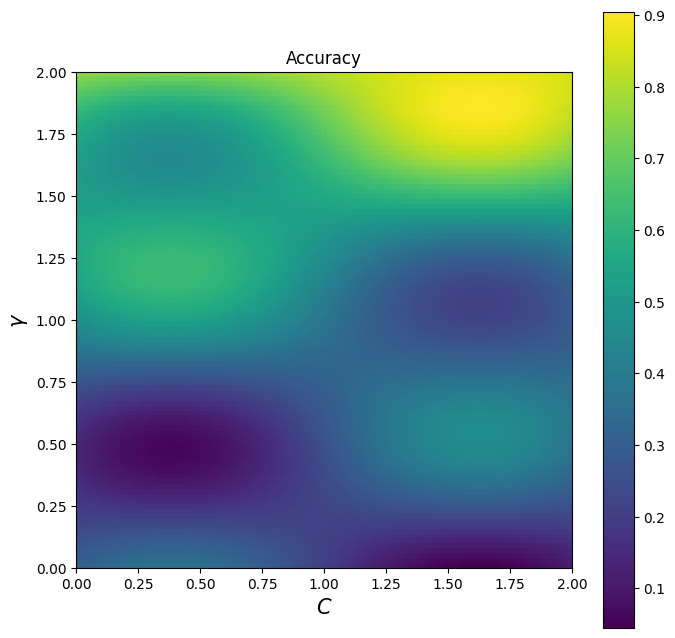

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))

heatmap = ax.imshow(ys.reshape(101, 101).T, origin='lower', extent=[0, 2, 0, 2])
ax.set_xlabel(r"$C$", fontsize=15)
ax.set_ylabel(r"$\gamma$", fontsize=15)
ax.set_title('Accuracy')

plt.colorbar(heatmap, ax=ax)
plt.show()

In [8]:
params = {
    'mean': jnp.zeros(()),
    'length_scale': jnp.zeros((2,)),
    'amplitude': jnp.zeros(()),
}

In [9]:
optimizer = optax.adam(0.01)

In [17]:
def fit(x_train, y_train):
    def prior(mean, length_scale, amplitude):
        return models.gaussian_process(
            means.constant(mean),
            kernels.scaled(kernels.matern_five_halves(nn.softplus(length_scale)), nn.softplus(amplitude)),
            1e-4,
        )

    def posterior(mean, length_scale, amplitude):
        return models.gaussian_process_regression(
            x_train,
            y_train,
            means.constant(mean),
            kernels.scaled(kernels.matern_five_halves(nn.softplus(length_scale)), nn.softplus(amplitude)),
            1e-4,
        )
    
    def target_log_prob(params):
        mean, cov = prior(**params)(x_train)
        return -scipy.stats.multivariate_normal.logpdf(y_train, mean, cov)

    def train_step(state, iteration):
        loss, grads = value_and_grad(target_log_prob)(state[0])
        updates, opt_state = optimizer.update(grads, state[1])
        params = optax.apply_updates(state[0], updates)
        
        return (params, opt_state), loss
    
    (next_params, next_opt_state), history = lax.scan(
        jit(train_step),
        (params, optimizer.init(params)),
        jnp.arange(500)
    )

    return posterior(**next_params)

In [24]:
num_queries = 20
batch_size = 4
num_iterations = num_queries // batch_size

In [25]:
num_restarts, num_raw_samples = 40, 100

In [32]:
def score(key, surrogate, best):    
    init_key, max_key, candidate_key = random.split(key, 3)
    
    init_samples = samplers.halton_normal()(init_key, num_raw_samples).flatten()
    init_acqf = acquisitions.q_probability_of_improvement(surrogate, init_samples, 1.0, best)
    
    max_samples = samplers.halton_normal()(max_key, num_restarts).flatten()
    max_acqf = acquisitions.q_probability_of_improvement(surrogate, max_samples, 1.0, best)
    
    maximizer = maximizers.bfgs(bounds, batch_size, num_restarts, num_raw_samples)
    candidates = maximizer.init(candidate_key, init_acqf)
    next_candidates, values = maximizer.maximize(candidates, max_acqf)

    return next_candidates[jnp.argmax(values)]

In [33]:
data_key, optimization_key = random.split(random.key(0))
x_train = random.uniform(data_key, minval=bounds[0, 0], maxval=bounds[0, 1], shape=(batch_size, 2))
y_train = objective(x_train)

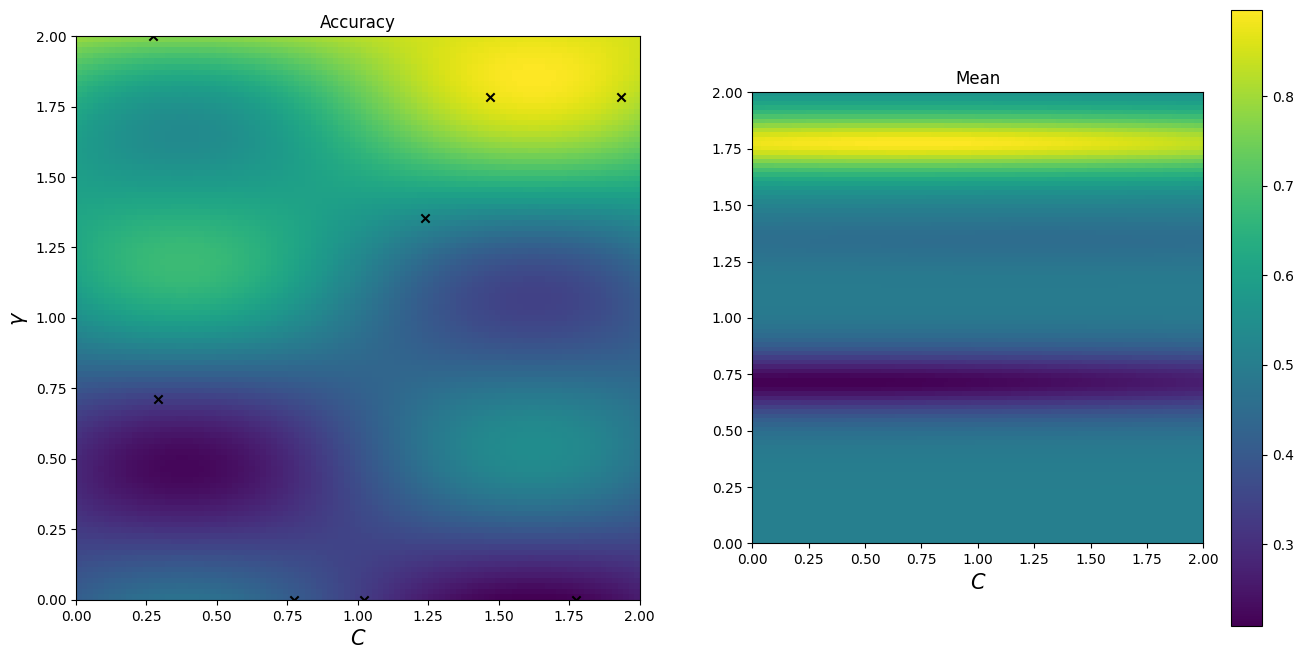

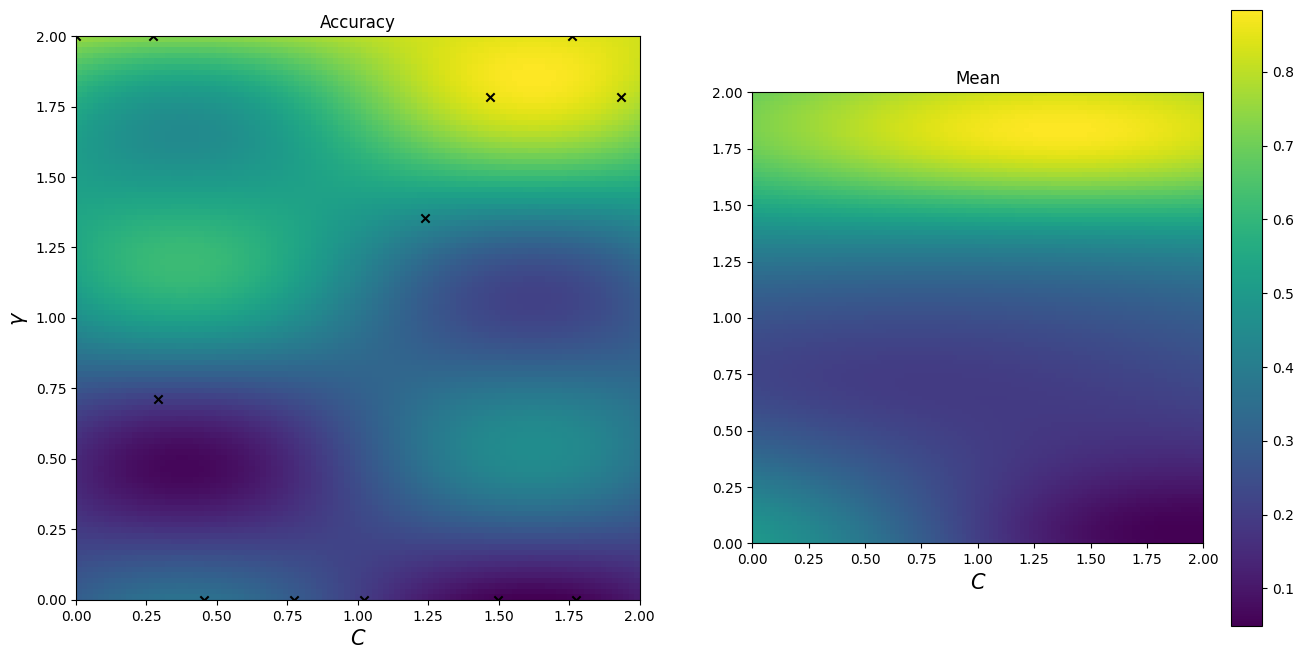

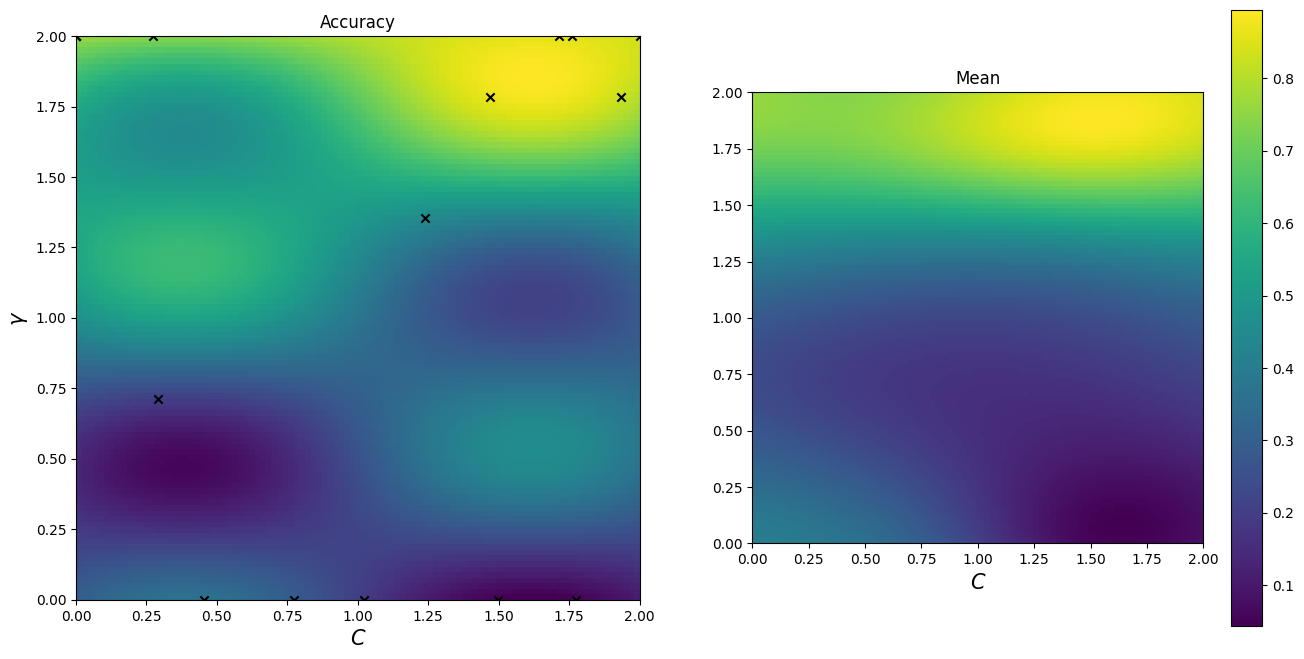

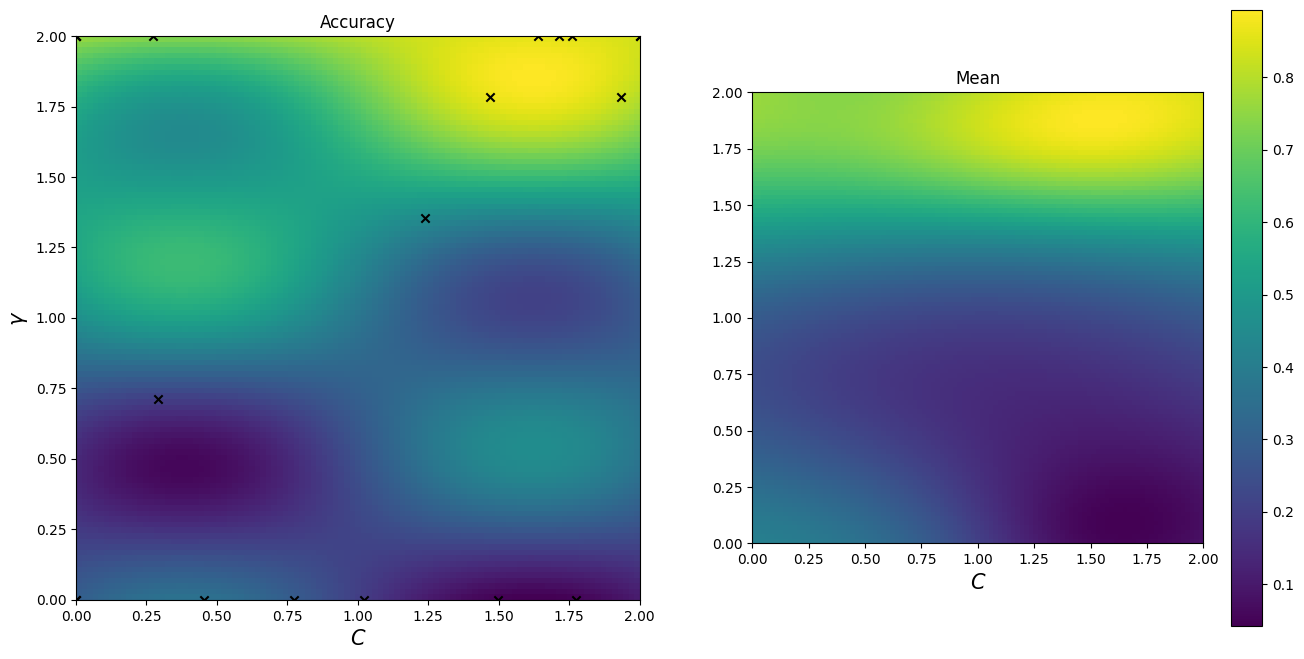

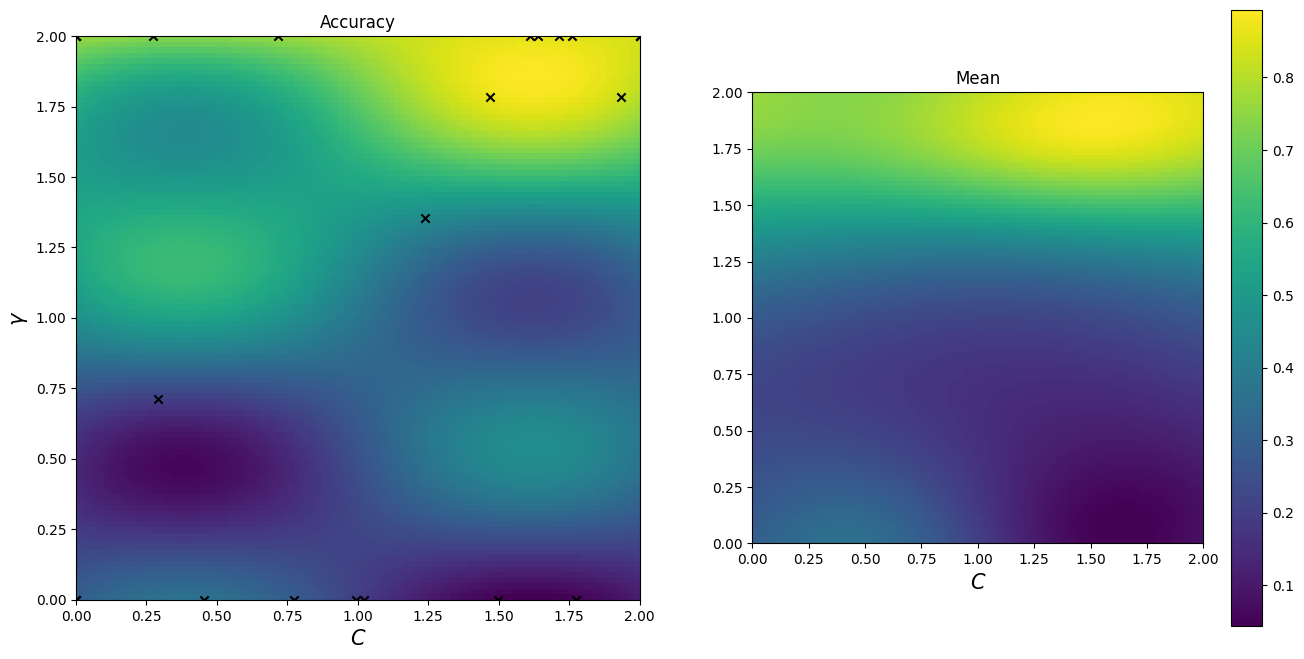

In [34]:
for i in range(num_iterations):
    surrogate = fit(x_train, y_train)
    best = jnp.max(y_train)
    
    next_x = score(random.fold_in(optimization_key, i), surrogate, best)
    next_y = objective(next_x)

    x_train = jnp.vstack([x_train, next_x])
    y_train = jnp.hstack([y_train, next_y])

    mean, cov = surrogate(xs)

    fig, axs = plt.subplots(1, 2, figsize=(16, 8))

    heatmap = axs[0].imshow(ys.reshape(101, 101).T, origin='lower', extent=[0, 2, 0, 2])
    axs[0].scatter(x_train[..., 0], x_train[..., 1], marker='x', color='k')
    axs[0].set_xlabel(r"$C$", fontsize=15)
    axs[0].set_ylabel(r"$\gamma$", fontsize=15)
    axs[0].set_title('Accuracy')

    heatmap = axs[1].imshow(mean.reshape(101, 101).T, origin='lower', extent=[0, 2, 0, 2])
    axs[1].set_xlabel(r"$C$", fontsize=15)
    axs[1].set_title('Mean')
    
    plt.colorbar(heatmap, ax=axs[1])
    plt.show()